<a href="https://colab.research.google.com/github/nehgu/RLtalk/blob/master/GoogleDopamine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install --upgrade --no-cache-dir dopamine-rl
!pip install cmake
!pip install atari-py

Requirement already up-to-date: dopamine-rl in /usr/local/lib/python3.6/dist-packages (2.0.1)


In [0]:
import numpy as np
import os
from dopamine.agents.dqn import dqn_agent
from absl import flags
from dopamine.discrete_domains import run_experiment
import dopamine.colab.utils as colab_utils
GAME = 'Asterix'
BASE_PATH = '/tmp/colab_dope_run'

In [23]:
import gin.tf
LOG_PATH = os.path.join(BASE_PATH, 'sticky_agent', GAME)

class StickyAgent(object):
  """This agent randomly selects an action and sticks to it. It will change
  actions with probability switch_prob."""
  def __init__(self, sess, num_actions, switch_prob=0.1):
    self._sess = sess
    self._num_actions = num_actions
    self._switch_prob = switch_prob
    self._last_action = np.random.randint(num_actions)
    self.eval_mode = False
    
  def _choose_action(self):
    if np.random.random() <= self._switch_prob:
      self._last_action = np.random.randint(self._num_actions)
    return self._last_action
    
  def bundle_and_checkpoint(self, unused_checkpoint_dir, unused_iteration):
    pass
    
  def unbundle(self, unused_checkpoint_dir, unused_checkpoint_version,
               unused_data):
    pass
  
  def begin_episode(self, unused_observation):
    return self._choose_action()
  
  def end_episode(self, unused_reward):
    pass
  
  def step(self, reward, observation):
    return self._choose_action()
  
def create_sticky_agent(sess, environment, summary_writer=None):
  """The Runner class will expect a function of this type to create an agent."""
  return StickyAgent(sess, num_actions=environment.action_space.n,
                     switch_prob=0.2)

sticky_config = """
import dopamine.discrete_domains.atari_lib
import dopamine.discrete_domains.run_experiment
atari_lib.create_atari_environment.game_name = '{}'
atari_lib.create_atari_environment.sticky_actions = True
run_experiment.Runner.num_iterations = 200
run_experiment.Runner.training_steps = 10
run_experiment.Runner.max_steps_per_episode = 100
""".format(GAME)
gin.parse_config(sticky_config, skip_unknown=False)

# Create the runner class with this agent. We use very small numbers of steps
# to terminate quickly, as this is mostly meant for demonstrating how one can
# use the framework.
sticky_runner = run_experiment.TrainRunner(LOG_PATH, create_sticky_agent)

INFO:tensorflow:Creating TrainRunner ...


In [24]:
# @title Train MyRandomDQNAgent.
print('Will train agent, please be patient, may be a while...')
sticky_runner.run_experiment()
print('Done training!')

Will train agent, please be patient, may be a while...
INFO:tensorflow:Beginning training...
INFO:tensorflow:Average undiscounted return per training episode: 100.00
INFO:tensorflow:Average training steps per second: 548.01
INFO:tensorflow:Average undiscounted return per training episode: 100.00
INFO:tensorflow:Average training steps per second: 667.54
INFO:tensorflow:Average undiscounted return per training episode: 50.00
INFO:tensorflow:Average training steps per second: 619.64
INFO:tensorflow:Average undiscounted return per training episode: 200.00
INFO:tensorflow:Average training steps per second: 648.66
INFO:tensorflow:Average undiscounted return per training episode: 150.00
INFO:tensorflow:Average training steps per second: 656.13
INFO:tensorflow:Average undiscounted return per training episode: 50.00
INFO:tensorflow:Average training steps per second: 674.40
INFO:tensorflow:Average undiscounted return per training episode: 50.00
INFO:tensorflow:Average training steps per second: 

In [40]:
#from colab_utils import sticky_data
experimental_data = colab_utils.load_baselines('/content')
sticky_data = colab_utils.read_experiment(log_path=LOG_PATH, verbose=True,summary_keys=['train_episode_returns'])
sticky_data['agent'] = 'StickyAgent'
sticky_data['run_number'] = 1
experimental_data[GAME] = experimental_data[GAME].merge(sticky_data,how='outer')

Reading statistics from: /tmp/colab_dope_run/sticky_agent/Asterix//logs/log_199


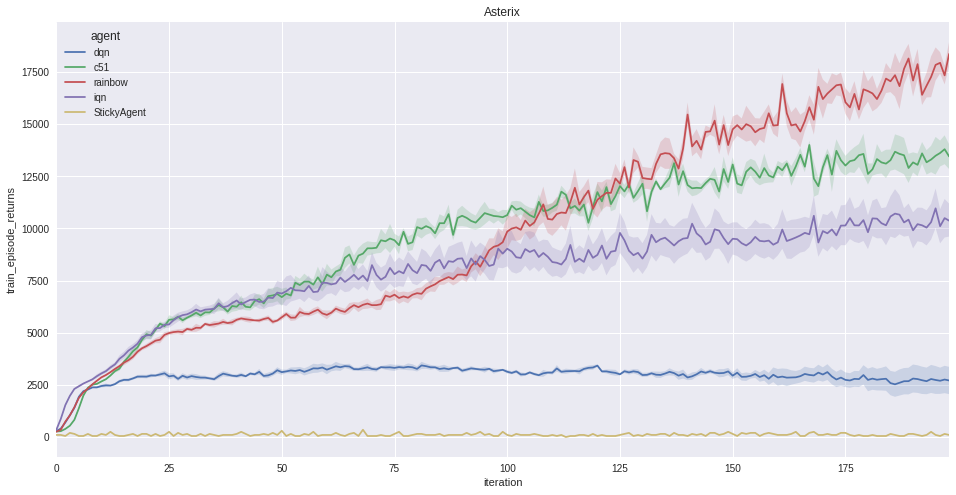

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize=(16,8))
sns.tsplot(data=experimental_data[GAME], time='iteration', unit='run_number',
             condition='agent', value='train_episode_returns', ax=ax)
plt.title(GAME)
plt.show()